### GOES-16 ABI and CUES

#### Analysis and plotting of cloud masks (2017-2019)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax
import seaborn as sn
# pretty print++ and pretty print
import pprintpp
pprintpp.monkeypatch()
import pprint

import warnings
warnings.filterwarnings('ignore')

# Import functions for computing summary statistics
import resampled_stats as rs

# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


Set font sizes for plots

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open dataset

CUES dataset which is the merged GOES-16 brightness temperature, GOES-16 ABI Cloud Mask, and CUES station data:

**Only look at before October 2019**

In [3]:
cues_dataset = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_dataset = cues_dataset.to_xarray().squeeze()
# Select only before October 2019 where we have the CUES sun flag
cues_ds = cues_dataset.where(cues_dataset.time < np.datetime64('2019-10-01'))

In [4]:
lw_allsky = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
lw_clearsky = cues_ds.lclr_mean
cues_ds['clear_sky_index'] = lw_allsky / lw_clearsky

In [5]:
cues_ds['csi_flag'] = cues_ds.clear_sky_index
cues_ds['csi_flag'][cues_ds.clear_sky_index <= 1] = 0
cues_ds['csi_flag'][cues_ds.clear_sky_index >1] = 1

### Filter entire dataset to only snow-on conditions, cloud-free, November through June each year

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where cloud_flag=0.

There are very few data points within Fall months, and we don't want to look at the summer past snowmelt. Filter to only look at November through June each year.

In [6]:
# Set snow depth threshold for filtering data to snow-on conditions only
snow_depth_treshold = 5 # cm

##### Create a dataset applying the clouds filter only
cues_cloud = cues_ds.where(cues_ds.ABI_Cloud_Mask == 0)

##### Filter just to snow-on conditions, during months Nov-June
filter_conditions_snowdepth_months = ((cues_ds.daily_median_snow_depth >= snow_depth_treshold) & \
                                      (cues_ds.time.dt.month.isin([1,2,3,4,5,6,11,12])))
cues_snow = cues_ds.where(filter_conditions_snowdepth_months) # Apply the filter, call this "cues_snow"

##### Create a third, combining the "snow" and "ABI cloud" filters
filter_conditions_ABIcloud_snowdepth_months = ((cues_ds.ABI_Cloud_Mask == 0) & \
                                               (cues_ds.daily_median_snow_depth >= snow_depth_treshold) & \
                                               (cues_ds.time.dt.month.isin([1,2,3,4,5,6,11,12])))
cues_snow_abicloud = cues_ds.where(filter_conditions_ABIcloud_snowdepth_months) # Apply this filter

##### Create a fourth, combining the "snow" and "in situ cloud" filters
filter_conditions_insitucloud_snowdepth_months = ((cues_ds.cloud_flag == 0) & \
                                                           (cues_ds.daily_median_snow_depth >= snow_depth_treshold) & \
                                                           (cues_ds.time.dt.month.isin([1,2,3,4,5,6,11,12])))
cues_snow_insitucloud = cues_ds.where(filter_conditions_insitucloud_snowdepth_months) # Apply this filter, insitu cloud filter

Make a plot showing the effect of trying to filter out cloud cover and only look at snow-on conditions:

Original, unfiltered GOES-16 ABI:
{
    'intercept': -8.751912427090293,
    'max_diff': 58.89857177734375,
    'mean_diff': -5.185510731500686,
    'mean_squared_diff': 230.17039520487702,
    'median_diff': 0.6812365722656253,
    'min_diff': -65.81564453125,
    'n': 142751,
    'p_value': 0.0,
    'r_value': 0.18236520476483692,
    'range_diff': 124.71421630859375,
    'rms_diff': 15.171367611552922,
    'slope': 0.433736399339131,
    'std_diff': 14.257660174740042,
    'std_err': 0.0061894613702071525,
}
ABI Cloud Mask filter only:
{
    'intercept': 2.5280421192449642,
    'max_diff': 58.89857177734375,
    'mean_diff': 4.173054289295944,
    'mean_squared_diff': 31.11372802895646,
    'median_diff': 4.065474853515626,
    'min_diff': -21.426844482421874,
    'n': 57159,
    'p_value': 0.0,
    'r_value': 0.846646498927142,
    'range_diff': 80.32541625976562,
    'rms_diff': 5.57796809142509,
    'slope': 0.7840172490479339,
    'std_diff': 3.7012627477045155,
    'std_err': 0

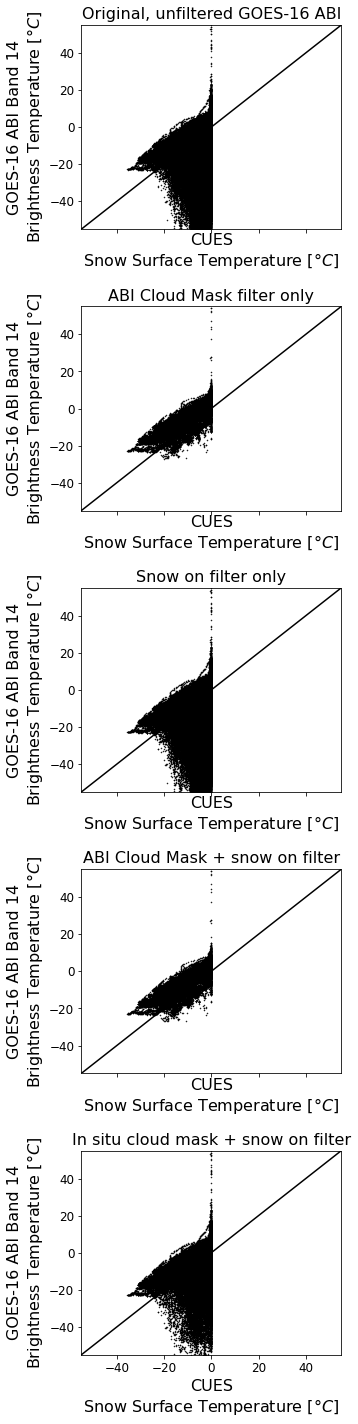

In [7]:
# set up plot figure and axes
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,20),sharex=True,sharey=True,tight_layout=True)
[ax1, ax2, ax3, ax4, ax5] = axes.ravel()

print("Original, unfiltered GOES-16 ABI:")
x1 = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_ds.goes_tb_c
pprint.pprint(rs.summary_stats(x1, y1))
ax1.set_title('Original, unfiltered GOES-16 ABI')
ax1.plot(x1, y1, '.k',alpha=1, markersize=1)

print("ABI Cloud Mask filter only:")
x2 = cues_cloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_cloud.goes_tb_c
pprint.pprint(rs.summary_stats(x2, y2))
ax2.set_title('ABI Cloud Mask filter only')
ax2.plot(x2, y2, '.k',alpha=1, markersize=1)

print("Snow on filter only:")
x3 = cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y3 = cues_snow.goes_tb_c
pprint.pprint(rs.summary_stats(x3, y3))
ax3.set_title('Snow on filter only')
ax3.plot(x3, y3, '.k',alpha=1, markersize=1)

print("ABI Cloud Mask + snow on filter:")
x4 = cues_snow_abicloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y4 = cues_snow_abicloud.goes_tb_c
pprint.pprint(rs.summary_stats(x4, y4))
ax4.set_title('ABI Cloud Mask + snow on filter')
ax4.plot(x4, y4, '.k',alpha=1, markersize=1)

print("In situ cloud mask + snow on filter:")
x5 = cues_snow_insitucloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y5 = cues_snow_insitucloud.goes_tb_c
pprint.pprint(rs.summary_stats(x5, y5))
ax5.set_title('In situ cloud mask + snow on filter')
ax5.plot(x5, y5, '.k',alpha=1, markersize=1)

# format axes
(min_lim, max_lim) = (-55, 55)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xlim((min_lim,max_lim))
    ax.set_ylim((min_lim,max_lim));
    ax.set_xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
    ax.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
    ax.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

Make a plot to preview some of this data showing snow melting away

What's actually going on with these different methods of trying to filter out clouds over snow?

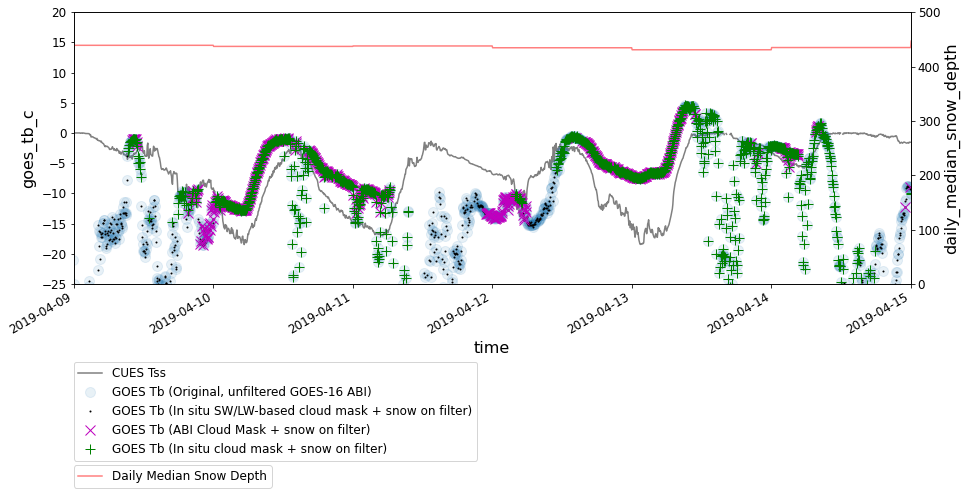

In [8]:
startdate = pd.Timestamp(2019,4,9)
enddate = pd.Timestamp(2019,4,15)

fig, ax = plt.subplots(1,1,figsize=(15,5))

cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='-', color='grey', ax=ax, label='CUES Tss')
cues_ds.goes_tb_c.plot(linestyle='none', marker='o', markersize=10, color='tab:blue', ax=ax, label='GOES Tb (Original, unfiltered GOES-16 ABI)', alpha=0.1)
cues_snow.goes_tb_c.plot(linestyle='none', marker='.', markersize=2, color='k', ax=ax, label='GOES Tb (In situ SW/LW-based cloud mask + snow on filter)')
cues_snow_abicloud.goes_tb_c.plot(linestyle='none', marker='x', markersize=10, color='m', ax=ax, label='GOES Tb (ABI Cloud Mask + snow on filter)')
cues_snow_insitucloud.goes_tb_c.plot(linestyle='none', marker='+', markersize=10, color='g', ax=ax, label='GOES Tb (In situ cloud mask + snow on filter)')


ymax = 20
ymin = -25
ax.set_ylim([ymin,ymax])

# plot the cloud mask (this is a binary, 0 or 1), multiply by ymax on the temperature scale so that it spans the plot vertically
#ax.plot(goes_cloudmask.datetime, goes_cloudmask.BCM, color='grey', alpha=0.3, label='GOES-16 Cloud Mask', zorder=0)
#ax.plot(cues_snow.datetime, cues_ds.cloud_flag,alpha=0.3, label='CUES Cloud Flag')


ax2 = ax.twinx()
ax2.set_ylim([0,500])
cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=ax2, alpha=0.5)

ax.set_xlim([startdate,enddate])
ax.legend(loc=(0,-.65))
ax2.legend(loc=(0,-.75))

* **In situ SW/LW-based cloud mask** is keeping too many cloud periods in the timeseries.
* **ABI Cloud Mask** flags clouds much more often than the **in situ** cloud flag, so when I combine the two the resulting combined cloud flag is just dominated by the **ABI cloud mask**

Where do the **ABI Cloud Mask** and **In Situ Cloud Mask** not match??

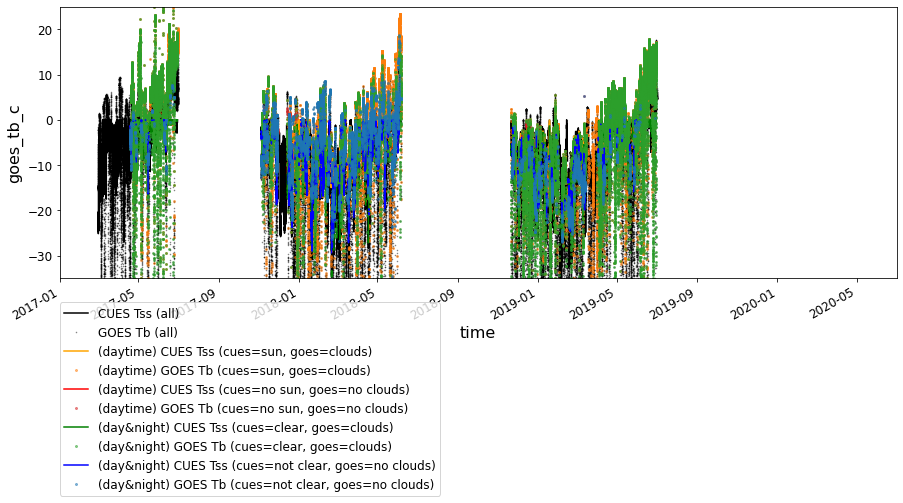

In [9]:
startdate = pd.Timestamp(2017,1,1)
enddate = pd.Timestamp(2020,7,1)

fig, ax = plt.subplots(1,1,figsize=(15,5))

# plot all datapoints for CUES Tss and GOES ABI Tb
cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='-', color='k', ax=ax, label='CUES Tss (all)')
cues_snow.goes_tb_c.plot(linestyle='none', marker='.', markersize=1, color='k', ax=ax, label='GOES Tb (all)', alpha=0.5)

# DAYTIME Condition where CUES sees the sun, but ABI says there are clouds
cloud_detect_mismatch_day1 = ((cues_snow.day_flag == 1) & (cues_snow.sun_flag == 1) & (cues_snow.ABI_Cloud_Mask == 1))
cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cloud_detect_mismatch_day1).plot(linestyle='-', color='orange', ax=ax, label='(daytime) CUES Tss (cues=sun, goes=clouds)')
cues_snow.goes_tb_c.where(cloud_detect_mismatch_day1).plot(linestyle='none', marker='o', markersize=2, color='tab:orange', ax=ax, label='(daytime) GOES Tb (cues=sun, goes=clouds)', alpha=0.5)

# DAYTIME Condition where CUES does not see the sun, and ABI says there are no clouds
cloud_detect_mismatch_day2 = ((cues_snow.day_flag == 1) & (cues_snow.sun_flag == 0) & (cues_snow.ABI_Cloud_Mask == 0))
cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cloud_detect_mismatch_day2).plot(linestyle='-', color='r', ax=ax, label='(daytime) CUES Tss (cues=no sun, goes=no clouds)')
cues_snow.goes_tb_c.where(cloud_detect_mismatch_day2).plot(linestyle='none', marker='o', markersize=2, color='tab:red', ax=ax, label='(daytime) GOES Tb (cues=no sun, goes=no clouds)', alpha=0.5)

# DAY & NIGHT Condition where CUES has clear skies (LWd <= LWd_clr), but ABI says there are clouds
#(cues_snow.day_flag == 0) & 
cloud_detect_mismatch_night1 = ((cues_snow['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'] <= cues_snow.lclr_mean) & (cues_snow.ABI_Cloud_Mask == 1))
cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cloud_detect_mismatch_night1).plot(linestyle='-', color='g', ax=ax, label='(day&night) CUES Tss (cues=clear, goes=clouds)')
cues_snow.goes_tb_c.where(cloud_detect_mismatch_night1).plot(linestyle='none', marker='o', markersize=2, color='tab:green', ax=ax, label='(day&night) GOES Tb (cues=clear, goes=clouds)', alpha=0.5)

# DAY & NIGHT Condition where CUES has cloudy skies (LWd > LWd_clr), but ABI says there are no clouds
#(cues_snow.day_flag == 0) & 
cloud_detect_mismatch_night2 = ((cues_snow['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'] > cues_snow.lclr_mean) & (cues_snow.ABI_Cloud_Mask == 0))
cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cloud_detect_mismatch_night2).plot(linestyle='-', color='b', ax=ax, label='(day&night) CUES Tss (cues=not clear, goes=no clouds)')
cues_snow.goes_tb_c.where(cloud_detect_mismatch_night2).plot(linestyle='none', marker='o', markersize=2, color='tab:blue', ax=ax, label='(day&night) GOES Tb (cues=not clear, goes=no clouds)', alpha=0.5)


#ax.plot(cues_ds.time,cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']/20)
#ax.plot(cues_ds.time,cues_ds.lclr_mean/20)


#ax.plot(cues_ds.time, cues_ds.sun_flag*20, c='k')
#ax.plot(cues_ds.time, cues_ds.ABI_Cloud_Mask*20, c='r', linestyle='--')
#cues_ds.cloud_flag.plot(ax=ax, alpha=0.5, color='b', label='CUES Cloud Flag')
#cues_ds.ABI_Cloud_Mask.plot(ax=ax, alpha=0.5, color='r', label='GOES Cloud Flag')

ymax = 25
ymin = -35
ax.set_ylim([ymin,ymax])

# plot the cloud mask (this is a binary, 0 or 1), multiply by ymax on the temperature scale so that it spans the plot vertically
#ax.plot(goes_cloudmask.datetime, goes_cloudmask.BCM, color='grey', alpha=0.3, label='GOES-16 Cloud Mask', zorder=0)
#ax.plot(cues_snow.datetime, cues_ds.cloud_flag,alpha=0.3, label='CUES Cloud Flag')


#ax2 = ax.twinx()
#ax2.set_ylim([0,600])
#cues_ds.daily_median_snow_depth.plot(color='k',label='Daily Median Snow Depth', ax=ax2, alpha=0.5)

ax.set_xlim([startdate,enddate])
ax.legend(loc=(0,-.8))
ax2.legend(loc=(0.3,-.6))

Compare means of some met variables when ABI sees the clouds, versus when ABI is missing the clouds

In [12]:
def groupby_mean_and_density_plot(xarray_groupby_object, smin=5, smax=100, color='k', label=''):
    
    x = np.array(list(xarray_groupby_object.groups.keys()))
    y = xarray_groupby_object.mean().values
    count = xarray_groupby_object.count().values
    s = smin + (count - min(count)) / (max(count) - min(count)) *  (smax - smin)
    scatter_ax = plt.scatter(x, y, s=s, color=color, label=label+' (N)');
    line_ax = plt.plot(x, y, color=color, label=label);
    
    return scatter_ax, line_ax

In [13]:
## ALL ABI CLOUD COVER DETECTION
#all_abi_cloud_tss = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
#all_abi_cloud_temperature = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
#all_abi_cloud_rh = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['Platform relative humidity; platform temperature/relative humidity; (percent)']
#all_abi_cloud_nir = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['upward looking near-IR radiation; uplooking Eppley Lab precision spectral pyranometer w/ IR filter; (Watts/meter^2)']
#all_abi_cloud_lw = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#all_abi_cloud_sw_direct = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['upward looking solar radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
#all_abi_cloud_sw_diffuse = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['upward looking diffuse radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
#all_abi_cloud_sun = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
#all_abi_cloud_lw_clr = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1).lclr_mean
#all_abi_cloud_hour_of_day = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['hour_of_day']
#all_abi_cloud_week = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['week']
#all_abi_cloud_month = cues_snow.where(cues_ds.ABI_Cloud_Mask == 1)['month']


##### FALSE POSITIVE ABI CLOUD DETECTION #####

# (SW) DAYTIME Condition where CUES does not detect cloud cover but ABI does
day_tss1 = cues_snow.where(cloud_detect_mismatch_day1)['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
day_temperature1 = cues_snow.where(cloud_detect_mismatch_day1)['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
day_air_snow_temp_diff1 = day_temperature1 - day_tss1
day_rh1 = cues_snow.where(cloud_detect_mismatch_day1)['Platform relative humidity; platform temperature/relative humidity; (percent)']
day_nir1 = cues_snow.where(cloud_detect_mismatch_day1)['upward looking near-IR radiation; uplooking Eppley Lab precision spectral pyranometer w/ IR filter; (Watts/meter^2)']
day_lw1 = cues_snow.where(cloud_detect_mismatch_day1)['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
day_sw_direct1 = cues_snow.where(cloud_detect_mismatch_day1)['upward looking solar radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
day_sw_diffuse1 = cues_snow.where(cloud_detect_mismatch_day1)['upward looking diffuse radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
day_sun1 = cues_snow.where(cloud_detect_mismatch_day1)['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
day_lw_clr1 = cues_snow.where(cloud_detect_mismatch_day1).lclr_mean
day_hour_of_day1 = cues_snow.where(cloud_detect_mismatch_day1)['hour_of_day']
day_week1 = cues_snow.where(cloud_detect_mismatch_day1)['week']
day_month1 = cues_snow.where(cloud_detect_mismatch_day1)['month']

# (LW) DAY & NIGHT Condition where CUES does not detect cloud cover but ABI does
night_tss1 = cues_snow.where(cloud_detect_mismatch_night1)['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
night_temperature1 = cues_snow.where(cloud_detect_mismatch_night1)['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
night_air_snow_temp_diff1 = night_temperature1 - night_tss1
night_rh1 = cues_snow.where(cloud_detect_mismatch_night1)['Platform relative humidity; platform temperature/relative humidity; (percent)']
night_nir1 = cues_snow.where(cloud_detect_mismatch_night1)['upward looking near-IR radiation; uplooking Eppley Lab precision spectral pyranometer w/ IR filter; (Watts/meter^2)']
night_lw1 = cues_snow.where(cloud_detect_mismatch_night1)['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
night_sw_direct1 = cues_snow.where(cloud_detect_mismatch_night1)['upward looking solar radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
night_sw_diffuse1 = cues_snow.where(cloud_detect_mismatch_night1)['upward looking diffuse radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
night_sun1 = cues_snow.where(cloud_detect_mismatch_night1)['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
night_lw_clr1 = cues_snow.where(cloud_detect_mismatch_night1).lclr_mean
night_hour_of_day1 = cues_snow.where(cloud_detect_mismatch_night1)['hour_of_day']
night_week1 = cues_snow.where(cloud_detect_mismatch_night1)['week']
night_month1 = cues_snow.where(cloud_detect_mismatch_night1)['month']


##### FALSE NEGATIVE ABI CLOUD DETECTION #####

# (SW) DAYTIME Condition where CUES detects cloud cover but ABI does not
day_tss2 = cues_snow.where(cloud_detect_mismatch_day2)['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
day_temperature2 = cues_snow.where(cloud_detect_mismatch_day2)['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
day_air_snow_temp_diff2 = day_temperature2 - day_tss2
day_rh2 = cues_snow.where(cloud_detect_mismatch_day2)['Platform relative humidity; platform temperature/relative humidity; (percent)']
day_nir2 = cues_snow.where(cloud_detect_mismatch_day2)['upward looking near-IR radiation; uplooking Eppley Lab precision spectral pyranometer w/ IR filter; (Watts/meter^2)']
day_lw2 = cues_snow.where(cloud_detect_mismatch_day2)['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
day_sw_direct2 = cues_snow.where(cloud_detect_mismatch_day2)['upward looking solar radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
day_sw_diffuse2 = cues_snow.where(cloud_detect_mismatch_day2)['upward looking diffuse radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
day_sun2 = cues_snow.where(cloud_detect_mismatch_day2)['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
day_lw_clr2 = cues_snow.where(cloud_detect_mismatch_day2).lclr_mean
day_hour_of_day2 = cues_snow.where(cloud_detect_mismatch_day2)['hour_of_day']
day_week2 = cues_snow.where(cloud_detect_mismatch_day2)['week']
day_month2 = cues_snow.where(cloud_detect_mismatch_day2)['month']

# (LW) DAY & NIGHT Condition where CUES detects cloud cover but ABI does not
night_tss2 = cues_snow.where(cloud_detect_mismatch_night2)['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
night_temperature2 = cues_snow.where(cloud_detect_mismatch_night2)['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
night_air_snow_temp_diff2 = night_temperature2 - night_tss2
night_rh2 = cues_snow.where(cloud_detect_mismatch_night2)['Platform relative humidity; platform temperature/relative humidity; (percent)']
night_nir2 = cues_snow.where(cloud_detect_mismatch_night2)['upward looking near-IR radiation; uplooking Eppley Lab precision spectral pyranometer w/ IR filter; (Watts/meter^2)']
night_lw2 = cues_snow.where(cloud_detect_mismatch_night2)['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
night_sw_direct2 = cues_snow.where(cloud_detect_mismatch_night2)['upward looking solar radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
night_sw_diffuse2 = cues_snow.where(cloud_detect_mismatch_night2)['upward looking diffuse radiation; uplooking Sunshine pyranometer  direct and diffuse; (Watts/meter^2)']
night_sun2 = cues_snow.where(cloud_detect_mismatch_night2)['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
night_lw_clr2 = cues_snow.where(cloud_detect_mismatch_night2).lclr_mean
night_hour_of_day2 = cues_snow.where(cloud_detect_mismatch_night2)['hour_of_day']
night_week2 = cues_snow.where(cloud_detect_mismatch_night2)['week']
night_month2 = cues_snow.where(cloud_detect_mismatch_night2)['month']


Text(0.5, 0, 'Hour of Day')

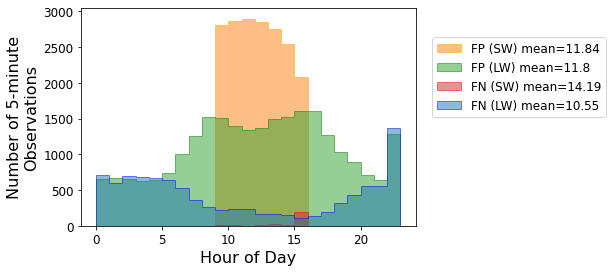

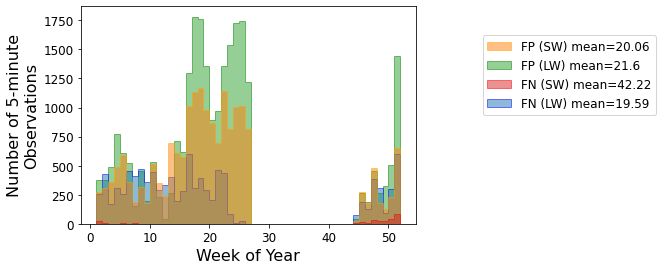

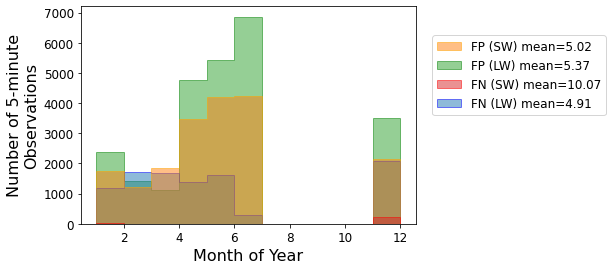

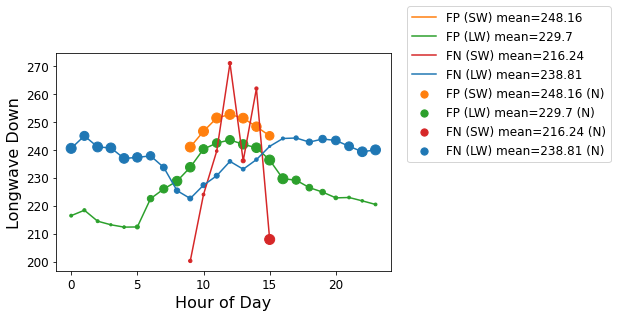

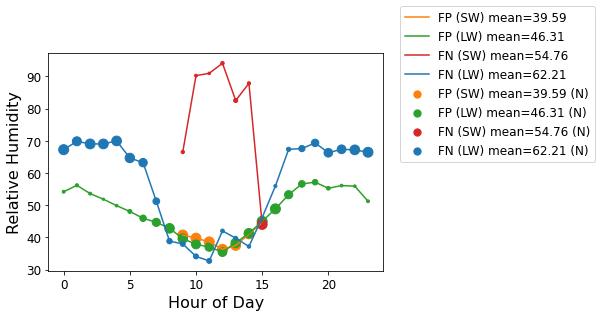

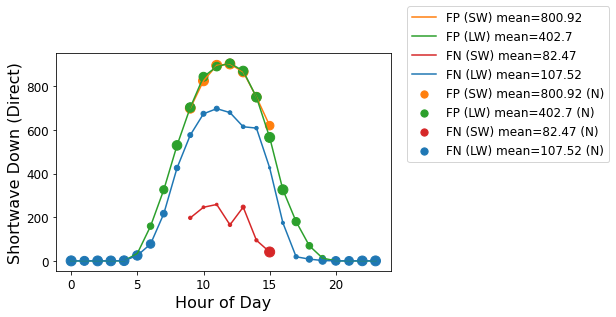

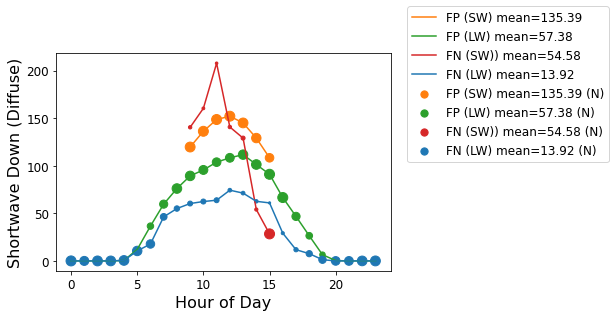

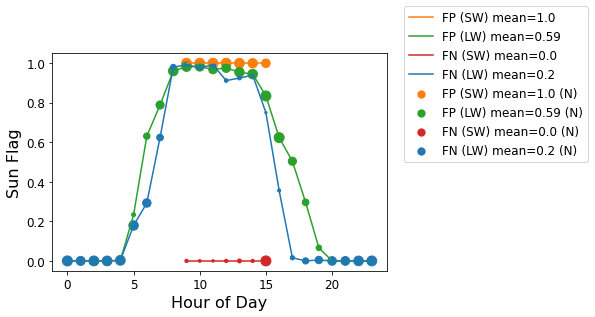

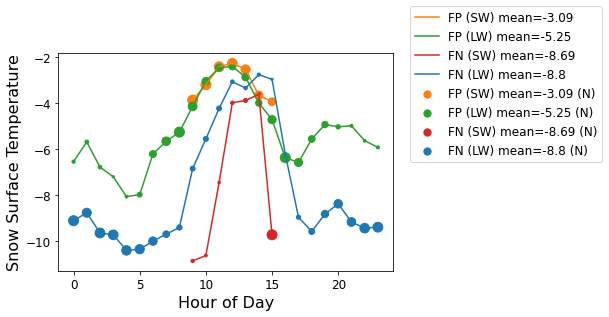

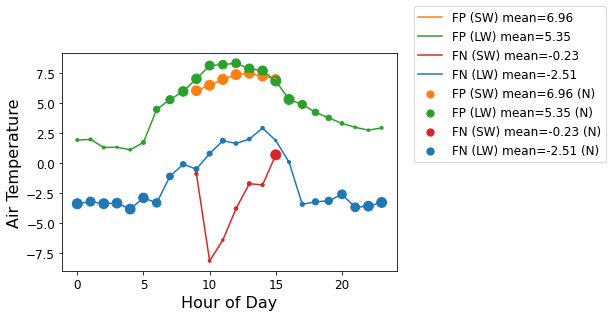

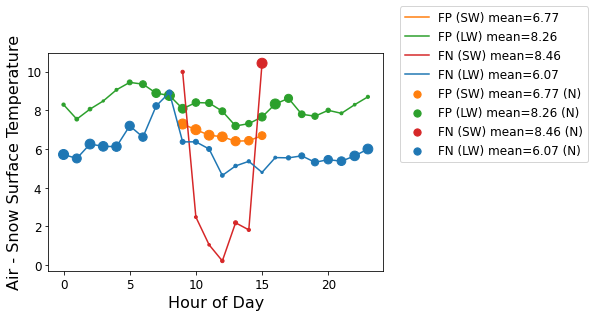

In [14]:

# Hour of day
plt.figure()
#plt.hist(all_abi_cloud_hour_of_day,bins=24, label='GOES detects clouds', color='tab:grey');
plt.hist(day_hour_of_day1,bins=range(0,24), label='FP (SW) mean={}'.format(np.round(np.nanmean(day_hour_of_day1.values),2)), ec='orange', fc='tab:orange', histtype='stepfilled', alpha=0.5);
plt.hist(night_hour_of_day1,bins=range(0,24), label='FP (LW) mean={}'.format(np.round(np.nanmean(night_hour_of_day1.values),2)),ec='g',  fc='tab:green', histtype='stepfilled', alpha=0.5);
plt.hist(day_hour_of_day2,bins=range(0,24), label='FN (SW) mean={}'.format(np.round(np.nanmean(day_hour_of_day2.values),2)),ec='r',  fc='tab:red', histtype='stepfilled', alpha=0.5);
plt.hist(night_hour_of_day2,bins=range(0,24), label='FN (LW) mean={}'.format(np.round(np.nanmean(night_hour_of_day2.values),2)),ec='b',  fc='tab:blue', histtype='stepfilled', alpha=0.5);

plt.legend(loc=(1.05,0.5))
plt.ylabel('Number of 5-minute\nObservations')
plt.xlabel('Hour of Day')


# Week
plt.figure()
#not_hist = plt.hist(all_abi_cloud_week,bins=52, label='GOES detects clouds', color='tab:grey');
hist = plt.hist(day_week1,bins=range(1,53), label='FP (SW) mean={}'.format(np.round(np.nanmean(day_week1.values),2)), ec='orange', fc='tab:orange', zorder=99, histtype='stepfilled', alpha=0.5);
hist = plt.hist(night_week1,bins=range(1,53), label='FP (LW) mean={}'.format(np.round(np.nanmean(night_week1.values),2)), ec='g', fc='tab:green', zorder=98, histtype='stepfilled', alpha=0.5);
hist = plt.hist(day_week2,bins=range(1,53), label='FN (SW) mean={}'.format(np.round(np.nanmean(day_week2.values),2)), ec='r', fc='tab:red', zorder=99, histtype='stepfilled', alpha=0.5);
hist = plt.hist(night_week2,bins=range(1,53), label='FN (LW) mean={}'.format(np.round(np.nanmean(night_week2.values),2)),ec='b',  fc='tab:blue', zorder=98, histtype='stepfilled', alpha=0.5);

plt.legend(loc=(1.2,0.5))
plt.ylabel('Number of 5-minute\nObservations')
plt.xlabel('Week of Year')


# Month
plt.figure()
#plt.hist(all_abi_cloud_month,bins=12, label='GOES detects clouds', color='tab:grey');
plt.hist(day_month1,bins=range(1,13), label='FP (SW) mean={}'.format(np.round(np.nanmean(day_month1.values),2)), ec='orange', fc='tab:orange', zorder=99, histtype='stepfilled', alpha=0.5);
plt.hist(night_month1,bins=range(1,13), label='FP (LW) mean={}'.format(np.round(np.nanmean(night_month1.values),2)),ec='g',  fc='tab:green', zorder=98, histtype='stepfilled', alpha=0.5);
plt.hist(day_month2,bins=range(1,13), label='FN (SW) mean={}'.format(np.round(np.nanmean(day_month2.values),2)),ec='r',  fc='tab:red', zorder=99, histtype='stepfilled', alpha=0.5);
plt.hist(night_month2,bins=range(1,13), label='FN (LW) mean={}'.format(np.round(np.nanmean(night_month2.values),2)),ec='b',  fc='tab:blue', zorder=98, histtype='stepfilled', alpha=0.5);
plt.legend(loc=(1.05,0.5))
plt.ylabel('Number of 5-minute\nObservations')
plt.xlabel('Month of Year')

# LWd
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_lw.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_lw1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_lw1.values),2)));
groupby_mean_and_density_plot(night_lw1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_lw1.values),2)));
groupby_mean_and_density_plot(day_lw2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_lw2.values),2)));
groupby_mean_and_density_plot(night_lw2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_lw2.values),2)));

plt.legend(loc=(1.05,0.5))
plt.ylabel('Longwave Down')
plt.xlabel('Hour of Day')

# RH
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_rh.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_rh1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_rh1.values),2)));
groupby_mean_and_density_plot(night_rh1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_rh1.values),2)));
groupby_mean_and_density_plot(day_rh2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_rh2.values),2)));
groupby_mean_and_density_plot(night_rh2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_rh2.values),2)));
plt.legend(loc=(1.05,0.5))
plt.ylabel('Relative Humidity')
plt.xlabel('Hour of Day')

# SW direct
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_sw_direct.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_sw_direct1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_sw_direct1.values),2)));
groupby_mean_and_density_plot(night_sw_direct1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_sw_direct1.values),2)));
groupby_mean_and_density_plot(day_sw_direct2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_sw_direct2.values),2)));
groupby_mean_and_density_plot(night_sw_direct2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_sw_direct2.values),2)));

plt.legend(loc=(1.05,0.5))
plt.ylabel('Shortwave Down (Direct)')
plt.xlabel('Hour of Day')

# SW diffuse
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_sw_diffuse.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_sw_diffuse1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_sw_diffuse1.values),2)));
groupby_mean_and_density_plot(night_sw_diffuse1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_sw_diffuse1.values),2)));
groupby_mean_and_density_plot(day_sw_diffuse2.groupby('time.hour'), color='tab:red', label='FN (SW)) mean={}'.format(np.round(np.nanmean(day_sw_diffuse2.values),2)));
groupby_mean_and_density_plot(night_sw_diffuse2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_sw_diffuse2.values),2)));

plt.legend(loc=(1.05,0.5))
plt.ylabel('Shortwave Down (Diffuse)')
plt.xlabel('Hour of Day')

# Sun
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_sun.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_sun1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_sun1.values),2)));
groupby_mean_and_density_plot(night_sun1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_sun1.values),2)));
groupby_mean_and_density_plot(day_sun2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_sun2.values),2)));
groupby_mean_and_density_plot(night_sun2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_sun2.values),2)));
plt.legend(loc=(1.05,0.5))
plt.ylabel('Sun Flag')
plt.xlabel('Hour of Day')

# TSS
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_tss.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_tss1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_tss1.values),2)));
groupby_mean_and_density_plot(night_tss1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_tss1.values),2)));
groupby_mean_and_density_plot(day_tss2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_tss2.values),2)));
groupby_mean_and_density_plot(night_tss2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_tss2.values),2)));
plt.legend(loc=(1.05,0.5))
plt.ylabel('Snow Surface Temperature')
plt.xlabel('Hour of Day')



# Temperature
plt.figure()
#groupby_mean_and_density_plot(all_abi_cloud_temperature.groupby('time.hour'), color='tab:grey', label='GOES detects clouds');
groupby_mean_and_density_plot(day_temperature1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_temperature1.values),2)));
groupby_mean_and_density_plot(night_temperature1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_temperature1.values),2)));
groupby_mean_and_density_plot(day_temperature2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_temperature2.values),2)));
groupby_mean_and_density_plot(night_temperature2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_temperature2.values),2)));
plt.legend(loc=(1.05,0.5))
plt.ylabel('Air Temperature')
plt.xlabel('Hour of Day')


# Air Temperature - Snow Temperature difference
# night_air_snow_temp_diff2
plt.figure()
groupby_mean_and_density_plot(day_air_snow_temp_diff1.groupby('time.hour'), color='tab:orange', label='FP (SW) mean={}'.format(np.round(np.nanmean(day_air_snow_temp_diff1.values),2)));
groupby_mean_and_density_plot(night_air_snow_temp_diff1.groupby('time.hour'), color='tab:green', label='FP (LW) mean={}'.format(np.round(np.nanmean(night_air_snow_temp_diff1.values),2)));
groupby_mean_and_density_plot(day_air_snow_temp_diff2.groupby('time.hour'), color='tab:red', label='FN (SW) mean={}'.format(np.round(np.nanmean(day_air_snow_temp_diff2.values),2)));
groupby_mean_and_density_plot(night_air_snow_temp_diff2.groupby('time.hour'), color='tab:blue', label='FN (LW) mean={}'.format(np.round(np.nanmean(night_air_snow_temp_diff2.values),2)));
plt.legend(loc=(1.05,0.5))
plt.ylabel('Air - Snow Surface Temperature')
plt.xlabel('Hour of Day')

---
---
### Confusion Matrices

In [13]:
def cm_scores(confusion_matrix):
    tp = confusion_matrix[1][1] # true positives
    fp = confusion_matrix[0][1] # false positives
    fn = confusion_matrix[1][0] # false negatives
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ( (precision * recall)/(precision + recall) )
    return precision, recall, f1_score

**CUES Sun Flag** versus **ABI Cloud Mask** DAYTIME ONLY

In [18]:
# CUES LW versus CUES SW cloud detection
# but we can only look where day_flag = 1
data = {'clouds_cues_sun_flag':    np.abs(cues_ds.sun_flag.where(cues_ds.day_flag==1).values - 1),
        'clouds_abi_mask':    cues_ds.ABI_Cloud_Mask.where(cues_ds.day_flag==1).values
        }

df = pd.DataFrame(data, columns=['clouds_cues_sun_flag','clouds_abi_mask'])


confusion_matrix = pd.crosstab(df['clouds_cues_sun_flag'], df['clouds_abi_mask'], rownames=['clouds_cues_sun_flag'], colnames=['clouds_abi_mask'], margins = True)

print(cm_scores(confusion_matrix))

confusion_matrix

#sn.heatmap(confusion_matrix, annot=True)
#plt.show()

(0.9837920053234469, 0.33950627409169193, 0.5048046436759183)


clouds_abi_mask,0.0,1.0,All
clouds_cues_sun_flag,,,
0.0,10754,40267,51021
1.0,341,20698,21039
All,11095,60965,72060


My **cloud_flag** (modified from clear sky index) versus **ABI Cloud Mask** DAY & NIGHT

In [19]:
# Not sure which one is "Actual" or "Predicted", but here I'm putting "CUES" first as if it's "actual"
data = {'clouds_cues_cloud_flag':    cues_ds.cloud_flag.values,
        'clouds_abi_mask':    cues_ds.ABI_Cloud_Mask.values
        }

df = pd.DataFrame(data, columns=['clouds_cues_cloud_flag','clouds_abi_mask'])


confusion_matrix = pd.crosstab(df['clouds_cues_cloud_flag'], df['clouds_abi_mask'], rownames=['clouds_cues_cloud_flag'], colnames=['clouds_abi_mask'], margins = True)

print(cm_scores(confusion_matrix))

confusion_matrix


#sn.heatmap(confusion_matrix, annot=True)
#plt.show()

(0.8971937858345791, 0.3201118035066873, 0.47186560777054604)


clouds_abi_mask,0.0,1.0,All
clouds_cues_cloud_flag,,,
0.0,96626,100703,197329
1.0,5433,47414,52847
All,102059,148117,250176


---

**CUES Sun Flag** versus **Clear Sky Index Flag** DAYTIME ONLY

In [20]:
## CUES LW versus CUES SW cloud detection
## but we can only look where day_flag = 1
#data = {'clouds_cues_sun_flag':    np.abs(cues_ds.sun_flag.where(cues_ds.day_flag==1).values - 1),
#        'clouds_CSI':    cues_ds.csi_flag.where(cues_ds.day_flag==1).values
#        }
#
#df = pd.DataFrame(data, columns=['clouds_cues_sun_flag','clouds_CSI'])
#
#
#confusion_matrix = pd.crosstab(df['clouds_cues_sun_flag'], df['clouds_CSI'], rownames=['clouds_cues_sun_flag'], colnames=['clouds_CSI'], margins = True)
#
#print(cm_scores(confusion_matrix))
#
#confusion_matrix
#
##sn.heatmap(confusion_matrix, annot=True)
##plt.show()

**CUES Sun flag** versus my **cloud_flag** (modified from clear sky index) DAYTIME ONLY

In [21]:
## CUES LW versus CUES SW cloud detection
## but we can only look where day_flag = 1
#data = {'clouds_cues_sun_flag':    np.abs(cues_ds.sun_flag.where(cues_ds.day_flag==1).values - 1),
#        'clouds_cues_cloud_flag':    cues_ds.cloud_flag.where(cues_ds.day_flag==1).values
#        }
#
#df = pd.DataFrame(data, columns=['clouds_cues_sun_flag','clouds_cues_cloud_flag'])
#
#
#confusion_matrix = pd.crosstab(df['clouds_cues_sun_flag'], df['clouds_cues_cloud_flag'], rownames=['clouds_cues_sun_flag'], colnames=['clouds_cues_cloud_flag'], margins = True)
#
#print(cm_scores(confusion_matrix))
#
#confusion_matrix
#
#
##sn.heatmap(confusion_matrix, annot=True)
##plt.show()

**Clear Sky Index Flag** versus **ABI Cloud Mask**

In [22]:
## Not sure which one is "Actual" or "Predicted", but here I'm putting "CUES" first as if it's "actual"
#data = {'clouds_CSI':    cues_ds.clear_sky_index.values,
#        'clouds_abi_mask':    cues_ds.ABI_Cloud_Mask.values
#        }
#
#df = pd.DataFrame(data, columns=['clouds_CSI','clouds_abi_mask'])
#
#
#confusion_matrix = pd.crosstab(df['clouds_CSI'], df['clouds_abi_mask'], rownames=['clouds_CSI'], colnames=['clouds_abi_mask'], margins = True)
#
#print(cm_scores(confusion_matrix))
#
#confusion_matrix
#
#
##sn.heatmap(confusion_matrix, annot=True)
##plt.show()